# SABBO
Version: 4.0<br>
Contents:<br>
Kaplan-Meier-Curve<br>
Python-Version: 3.11.17


###### tsolve = survivalTime

In [1]:
import csv
import pandas as pd
import math
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn import metrics
from numpy import *
from collections import Counter
from scipy.stats import shapiro
import warnings
import scipy
import pylab
from scipy.optimize.minpack import curve_fit

from scipy import odr, stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import svm

from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

C:\Users\deniz\AppData\Local\Temp\ipykernel_13340\1885206441.py:14: DeprecationWarning: Please use `curve_fit` from the `scipy.optimize` namespace, the `scipy.optimize.minpack` namespace is deprecated.
  from scipy.optimize.minpack import curve_fit


In [2]:
# Read CSV
csv_file = 'QUBOClusteringData.csv'

originDf = pd.read_csv(csv_file)

originDf.head()
    

,tsolve,alg,nvars,seed,runseed
0,8.0,UEDA,5,1,1
1,7.0,GR,5,1,1
2,13.0,RS,5,1,1
3,73.0,UEDA,5,1,2
4,4.0,GR,5,1,2


#### Functions:

### Topic 1: Kaplan-Meier-Curve
Algorithms end only after unkown time due to unknown issues.
The seed might or might not affect its performance, too. Thus, there are multiple ways in order to retrieve q.

The first Kaplan-Meier-Curves take the different seed into account and assign the last time depending on the seed.<br>
The second Kaplan-Meier-Curves take only the very last time for the number of variables regardless of the seed.

In [3]:
# Make the m-n-q Dataframe 
# @Bool Slots=True: with assignment of each seeds highest runtime for nvars
# @Bool Slots=False: the non-Runtimes retrieve the very highest time for nvars
def makeMNQDf(nvars, alg, slots):
    OrigDf = originDf[(originDf["alg"] == alg) & (originDf["nvars"] == nvars)]
    # Slots:
    if slots:
        maxTSolverPerSeedUEDA = OrigDf[OrigDf["alg"] == alg].groupby("seed")['tsolve'].max().to_dict()

        MNDf = OrigDf[(OrigDf["alg"] == alg) & (OrigDf["nvars"] == nvars)].copy()
        
        for index, row in MNDf.iterrows():
            if pd.isna(row["tsolve"]):
                if pd.isna(maxTSolverPerSeedUEDA[row["seed"]]):
                    maxRuntimeOverall = np.nanmax(list(maxTSolverPerSeedUEDA.values()))
                    MNDf.loc[index, "q SeedZeit"] = maxRuntimeOverall
                else:
                    MNDf.loc[index, "q SeedZeit"] = maxTSolverPerSeedUEDA[row["seed"]]
       
        ArgDf = MNDf.set_index("tsolve").sort_index()

        # make mDict
        allTimes = ArgDf.index.tolist()
        allTimes = [value for value in allTimes if not pd.isna(value)]  # [3.0, 29.0, 31.0, 31.0, 35.0, 45.0, 59.0, 60.0, 65.0, 69.0, 78.0, 81.0, 82.0, 83.0, 85.0, 89.0, 92.0, 96.0, 99.0, 100.0, 102.0, 104.0, 106.0, 107.0, 109.0, 112.0, 115.0, 122.0, 137.0, 144.0, 159.0, 165.0, 168.0, 174.0, 181.0, 212.0, 230.0, 234.0, 235.0, 245.0, 246.0, 258.0, 295.0, 304.0, 313.0, 327.0, 341.0, 343.0, 366.0, 374.0, 375.0, 386.0, 404.0, 415.0, 436.0, 438.0, 474.0, 500.0]

        tmp = Counter(allTimes)
        mDict = dict(tmp)
        mDict[0] = 0
        mDict = dict(sorted(mDict.items(), key=lambda x: x[0]))

    
    # !Slots:
    else:
        ArgDf = OrigDf
        MNDf = OrigDf.copy()
        maxRuntime = max(MNDf["tsolve"])
        MNDf.loc[pd.isna(MNDf["tsolve"]), "q SeedZeit"] = maxRuntime
        MNDf = MNDf.set_index("tsolve").sort_index()

        # make m Dict
        allTimes = MNDf.index.tolist()
        allTimes = [value for value in allTimes if not pd.isna(value)]  # [3.0, 29.0, 31.0, 31.0, 35.0, 45.0, 59.0, 60.0, 65.0, 69.0, 78.0, 81.0, 82.0, 83.0, 85.0, 89.0, 92.0, 96.0, 99.0, 100.0, 102.0, 104.0, 106.0, 107.0, 109.0, 112.0, 115.0, 122.0, 137.0, 144.0, 159.0, 165.0, 168.0, 174.0, 181.0, 212.0, 230.0, 234.0, 235.0, 245.0, 246.0, 258.0, 295.0, 304.0, 313.0, 327.0, 341.0, 343.0, 366.0, 374.0, 375.0, 386.0, 404.0, 415.0, 436.0, 438.0, 474.0, 500.0]

        tmp = Counter(allTimes)
        mDict = dict(tmp)
        mDict[0] = 0
        mDict = dict(sorted(mDict.items(), key=lambda x: x[0]))


    # From here calculate for both in the same manner
    # make qDict
    qDict = {key: 0 for key in mDict}
    try:
        values = list(MNDf["q SeedZeit"].dropna())
    except:
        values = []
    for value in values:
        qDict[value] += 1
        
 
    mDf = pd.DataFrame.from_dict(mDict, orient="index", columns=["m Died"])
    qDf = pd.DataFrame.from_dict(qDict, orient="index", columns=["q Censored"])
    dfOverall = pd.merge(mDf, qDf, left_index=True, right_index=True, how="outer")
    
    # make nDict
    totalRuns = len(ArgDf)  # 100
    nCurrent = totalRuns
    nDict = {key: 0 for key in mDict}
    
    a = 1
    for index, row in dfOverall.iterrows():
        if index == 0.0:
            nDict[index] = totalRuns
            nCurrent = totalRuns
            a = a + 1
        else:
            nDict[index] = nCurrent - row["m Died"] - row["q Censored"]
            nCurrent = nDict[index]    
    values = list(nDict.values())
    keys = list(nDict.keys())
    values.append(totalRuns)
    values = sorted(values, reverse=True) # [100, 100, 90, 89, 88, 87, 78, 69, 0]
    values.pop()
    nDict = dict(zip(keys, values))


    nDf = pd.DataFrame.from_dict(nDict, orient="index", columns=["n at Risk"])

    dfOverall = pd.merge(dfOverall, nDf, left_index=True, right_index=True, how="outer")
    MNQDf = dfOverall

    MNQDf["S(t)"] = (MNQDf["n at Risk"] - MNQDf["m Died"])/MNQDf["n at Risk"]
    pDict = {}

    for index, row in MNQDf.iterrows():
        if index == 0.0:
            pDict[index] = row["S(t)"]
            tmp = pDict[index]
        else:
            pDict[index] = tmp * row["S(t)"]
            tmp = pDict[index]
    pDf = pd.DataFrame.from_dict(pDict, orient="index", columns=["p(S(t))"])
    MNQDf = pd.merge(MNQDf, pDf, left_index=True, right_index=True, how="outer")
    MNQDf["nvar"] = nvars

    del mDict
    
    return MNQDf
 
# Plot one Curve     
def plotKaplanMeier(MNQDf):
    plt.plot(MNQDf.index, MNQDf['p(S(t))'], label='p(S(t))')
    plt.title('Kaplan-Meier-Curve')
    plt.xlabel('Time')
    plt.ylabel('S(t)')
    plt.legend()
    plt.show()


# Plot Multiple Kaplan-Meier-Curves into one image
def KaplansPlotter(nvarsList, alg, slots):
    fig, ax = plt.subplots(figsize=(10, 6))

    for var in nvarsList:
        MNQDf = makeMNQDf(var, alg, slots)
        ax.plot(MNQDf['p(S(t))'], label=f'nvar={var}')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Time')
    ax.set_ylabel('Survivors')
    ax.set_title(f'Kaplan-Meier-Curve of {alg}')

    plt.show()


In [4]:
# make multiple ideal curves into one image and plot not-solved ones
nvarsUEDAset = nvarsGRset = nvarsRSset = set()
nseedsUEDAset = nseedsGRset = nseedsRSset = set()

for index, row in originDf.iterrows():
    if row["alg"] == "UEDA":
        nvarsUEDAset.add(int(row["nvars"]))       # {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
        nseedsUEDAset.add(int(row["seed"]))       # {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    elif row["alg"] == "GR":
        nvarsGRset.add(int(row["nvars"]))         # {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
        nseedsGRset.add(int(row["seed"]))         # {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    elif row["alg"] == "RS":
        nvarsRSset.add(int(row["nvars"]))         # {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
        nseedsRSset.add(int(row["seed"]))         # {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

nvarsUEDA = list(nvarsUEDAset)
nvarsGR = list(nvarsGRset)
nvarsRS = list(nvarsRSset)
nseedsUEDA = list(nseedsUEDAset)
nseedsGR = list(nseedsGRset)
nseedsRS = list(nseedsRSset)

In [5]:
MNQDf = makeMNQDf(15, "UEDA", slots=False)
MNQDf.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,15
91.0,1,0,100,0.990000,0.99,15
94.0,1,0,99,0.989899,0.98,15
98.0,1,0,98,0.989796,0.97,15
100.0,1,0,97,0.989691,0.96,15


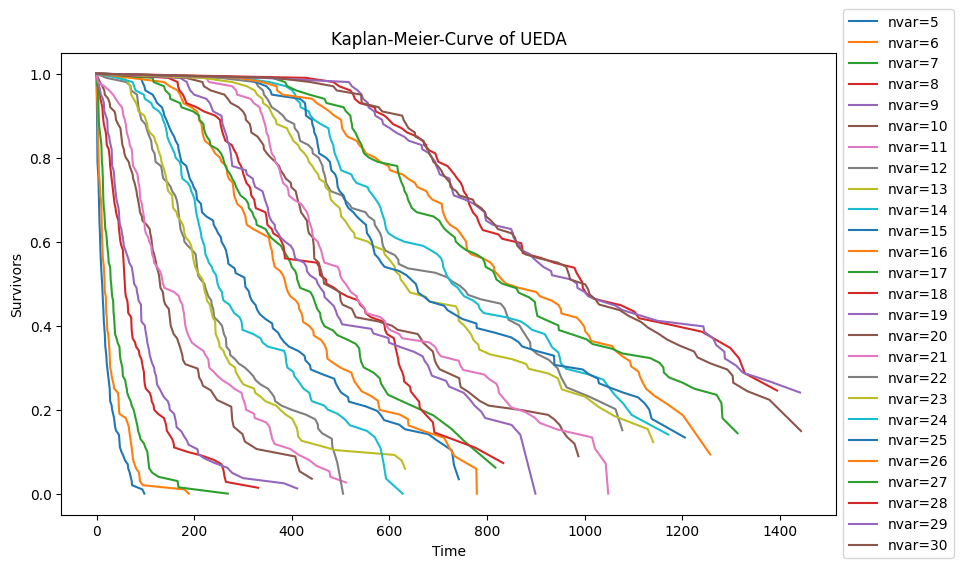

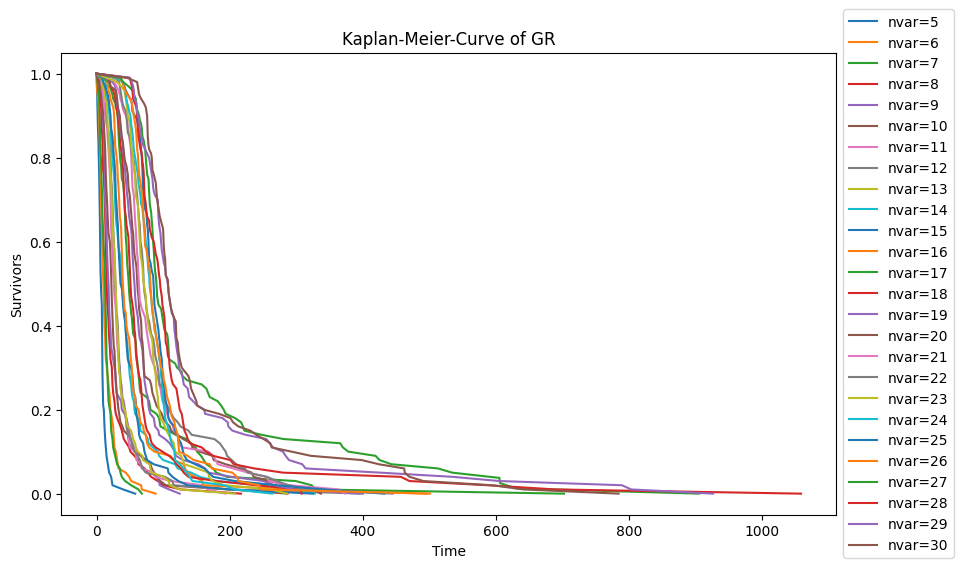

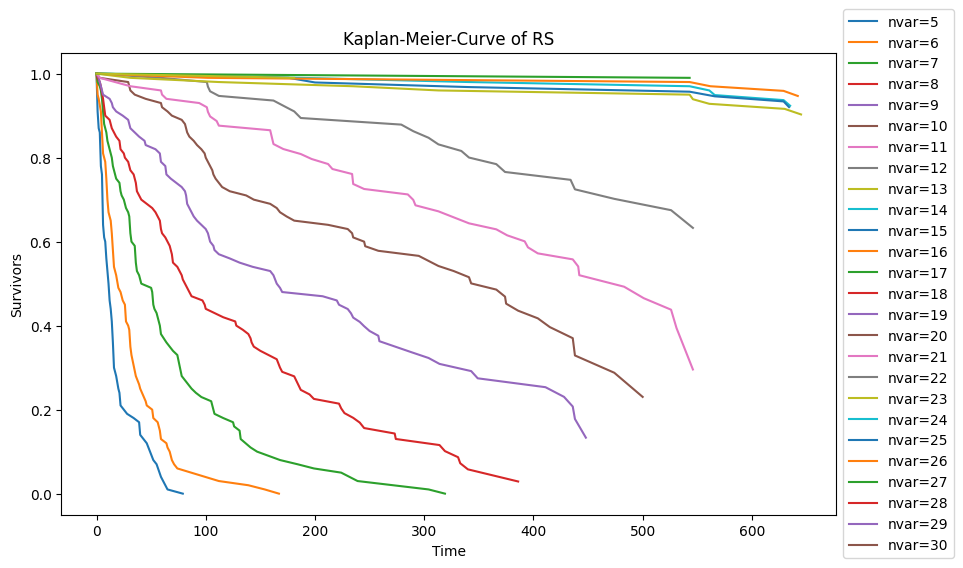

In [6]:
KaplansPlotter(nvarsUEDA, "UEDA", slots=True)
KaplansPlotter(nvarsGR, "GR", slots=True)
KaplansPlotter(nvarsRS, "RS", slots=True)

#### Topic 2: Generating predictions with the Kaplan-Meier-Curve
In this chapter, different ideas of generating predictions of the runtime with the Kaplan-Meier-Curves are investigated. The therefore investigated parameters are the Number of Variables (nvars), Runtime (tsolve) and Algorith (alg).<br>
The first approach is the moving average for time series with different intervals. It will be shown, that the hypothesis H_0 of standard distribution is refused and therefore this approach will be repudiated.<br>
Then different models will be fitted to each curve and therefore functions in order to approximate each runtime.

In [7]:
MNQDf = makeMNQDf(10, "UEDA", slots=False)
MNQDf

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,10
3.0,1,0,100,0.990000,0.99,10
7.0,1,0,99,0.989899,0.98,10
12.0,1,0,98,0.989796,0.97,10
16.0,1,0,97,0.989691,0.96,10
...,...,...,...,...,...,...
328.0,1,0,17,0.941176,0.16,10
407.0,1,0,16,0.937500,0.15,10
411.0,1,0,15,0.933333,0.14,10
416.0,1,0,14,0.928571,0.13,10


In [8]:
testDict = {
    'index': [1, 2, 3, 4, 5, 6, 7, 8],
    'p(S(t))': [22, 26, 30, 27, 24, 28, 31, 27],
}

testDf = pd.DataFrame(testDict, index=testDict["index"])
testDf = testDf.drop(columns=["index"])

testDf


,p(S(t))
1,22
2,26
3,30
4,27
5,24
6,28
7,31
8,27


In [9]:
# MNQDf = testDf

def regMovingAvg(MNQDf, windowSize):
    # make dict out of MNQDf
    sliderPointer = 0
    MNQDict = MNQDf['p(S(t))'].to_dict()
    PValDict = list(MNQDict.values())
    SAVal = dict()
    SAResult = []
    summarizer = []
    
    # even windowSize
    if windowSize % 2 == 0:
        for a in range(len(PValDict)):
            sliderPointer = a
            try:
                for i in range(windowSize+1):
                    summarizer.append(PValDict[sliderPointer])
                    sliderPointer+=1
            except IndexError:
                summarizer.append(np.nan)
                sliderPointer+=1
            val = (1/windowSize) * summarizer[0] + (1/windowSize) * summarizer[len(summarizer)-1]
            del summarizer[0]
            del summarizer[len(summarizer)-1]
            val = val + sum(summarizer)
            key = a+1           # index
            SAVal[key] = val
            summarizer.clear()
            SAVal = {key: value for key, value in SAVal.items() if not pd.isna(value)}

    else:
        for a in range(len(PValDict)):
            sliderPointer = a
            try:
                for i in range(windowSize):
                    summarizer.append(PValDict[sliderPointer])
                    sliderPointer+=1
            except IndexError:
                summarizer.append(np.nan)
                sliderPointer+=1
            val = sum(summarizer) / windowSize
            key = a+1           # index
            SAVal[key] = val
            summarizer.clear()
            SAVal = {key: value for key, value in SAVal.items() if not pd.isna(value)}

    # make the format of SAVal the same as for all other columns
    appender = int((windowSize-1)/2)
    for i in range(appender):
        SAResult.append(np.nan)
    for value in SAVal.values():
        SAResult.append(value)
    for i in range(appender):
        SAResult.append(np.nan)

    del summarizer, val, key, SAVal, sliderPointer
    return SAResult


MNQDf["Smoother"] = regMovingAvg(MNQDf, 3)
MNQDf

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar,Smoother
0.0,0,0,100,1.000000,1.00,10,NaN
3.0,1,0,100,0.990000,0.99,10,0.99
7.0,1,0,99,0.989899,0.98,10,0.98
12.0,1,0,98,0.989796,0.97,10,0.97
16.0,1,0,97,0.989691,0.96,10,0.96
...,...,...,...,...,...,...,...
328.0,1,0,17,0.941176,0.16,10,0.16
407.0,1,0,16,0.937500,0.15,10,0.15
411.0,1,0,15,0.933333,0.14,10,0.14
416.0,1,0,14,0.928571,0.13,10,0.13


In [10]:
MNQDf = MNQDf.drop(columns="Smoother")

Unfortunately, the time slots are irregular; A dependency can be seen nevertheless. For calculating such distribution, it's usually recommended to assume, that all data follows a Standard Distribution in order to calculate irregular, moving averages. In the following, a scrutiny of Standard Distribution is undergone. If applicable, the irregular average function will be shown, elsewise the model will be refused.

In [11]:
# test via Shaphiro-Wilk test for normality
dataRow = MNQDf["p(S(t))"]

stat, pVal = shapiro(dataRow)
alpha = 0.05

if pVal > alpha:
    print("The row of data likely follows a normal distribution.")
else:
    print(f"The row of data has p value of approximately {pVal}.\nIt therefore does not follow a normal distribution.")

The row of data has p value of approximately 0.003407829673960805.
It therefore does not follow a normal distribution.


The Shaphiro-Wilk test has proven, that the moving average with standard distribution will not be suitable in order to smooth the data of the timeseries.<br><br>
The new approach follows fitting different models for each of the Kapplan-Meier-Curves.<br>
The idea behind it is being displayed for UEDA, nvars=7, 13, 21 and 25, slots=True
And GR, nvars=4, 7, 13 and 21 slots= True


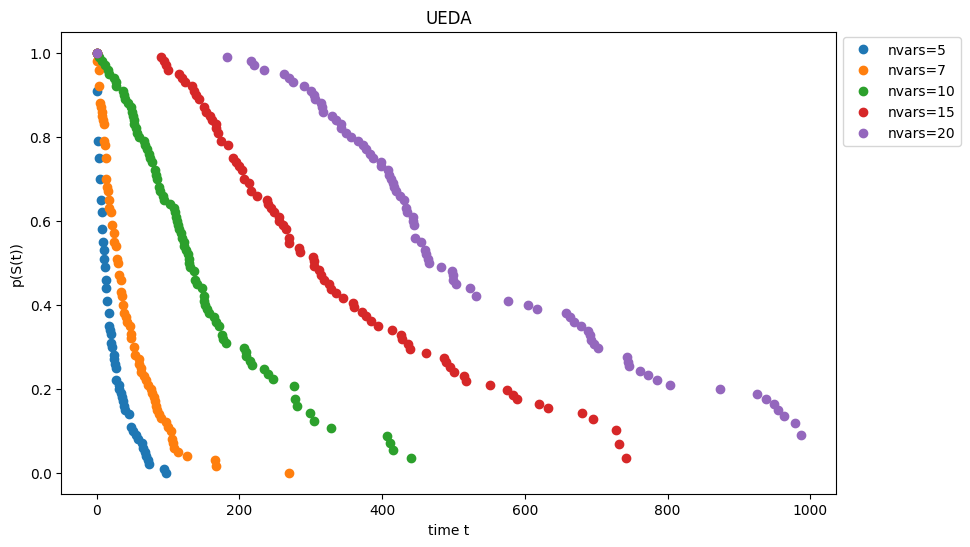

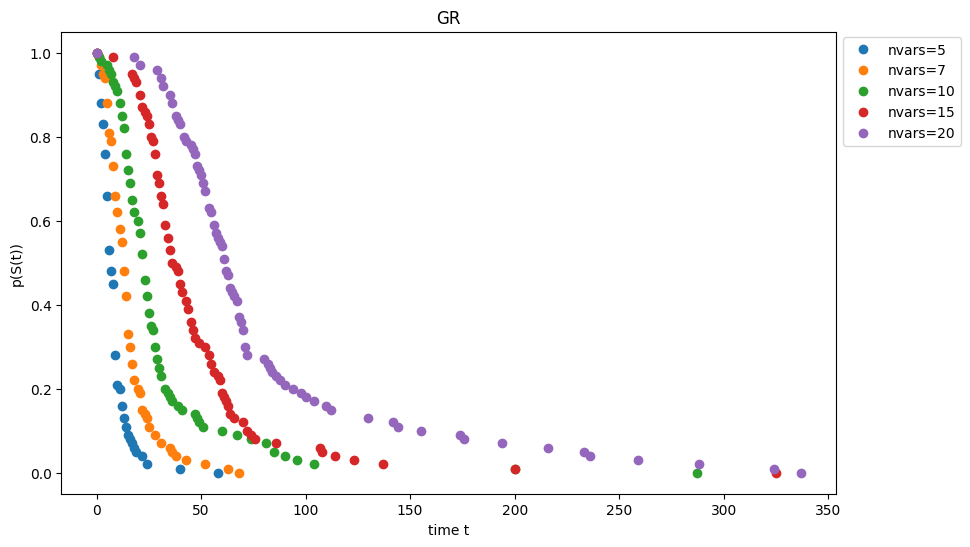

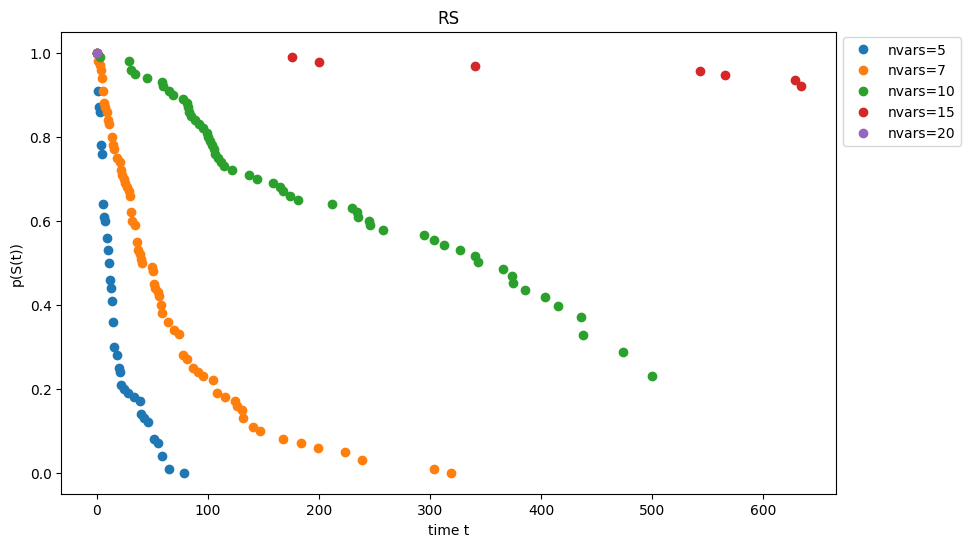

In [12]:
# Hand over array with numbers for each alg
# @Dependency: depends on MakeMNQDf
def plotMaker(arrayo, alg, slots):
    MNQDfDict = dict()
    plt.figure(figsize=(10, 6))
    for nvar in arrayo:
        MNQDf = makeMNQDf(nvar, alg, slots)
        name = f'MNQDf{nvar}{alg}'
        MNQDfDict[name]=MNQDf
        plt.plot(MNQDf.index, MNQDf["p(S(t))"], marker="o", linestyle="None", label=f'nvars={nvar}')

    plt.title(alg)
    plt.xlabel('time t')
    plt.ylabel('p(S(t))')
    plt.grid(False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.87))
    plt.show()

    return MNQDfDict

nvars=[5, 7, 10, 15, 20]
UEDADict = plotMaker(nvars, "UEDA", True)
GRDict = plotMaker(nvars, "GR", True)
RSDict = plotMaker(nvars, "RS", True)

In [13]:
MNQDf = makeMNQDf(10, "RS", True)
MNQDf.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,10
3.0,1,0,100,0.990000,0.99,10
29.0,1,0,99,0.989899,0.98,10
31.0,2,0,98,0.979592,0.96,10
35.0,1,0,96,0.989583,0.95,10


In [14]:
# @param img: Boolean decides whether an img will be displayed
def doSimpleLinearRegression(ArrMNQDf, alg, img):
        all_errors = []
    
        for dataDict in ArrMNQDf:
                if len(dataDict) > 1:
                        nvar = dataDict["nvar"].iloc[0]
                        x = np.array(dataDict.index)
                        x = x.reshape(-1, 1)
                        y = np.array(dataDict["p(S(t))"])
                        xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)
                        reg = LinearRegression().fit(xTrain, yTrain)
                        yPred = reg.predict(xTest)

                        mae = mean_absolute_error(yTest, yPred)
                        mse = mean_squared_error(yTest, yPred)
                        name1 = f"mae{nvar}"
                        name2 = f"mse{nvar}"

                        errorArr = {name1: mae, name2: mse}
                        all_errors.append(errorArr)
                        if img:
                                plt.plot(xTest, yPred, label=f'nvar={nvar}')
                                plt.scatter(x, y)
        if img:
                plt.axhline(y=0, color='black', linestyle='--', label='y=0')
                plt.xlabel('Time')
                plt.ylabel('p(S(t))')
                plt.title(f'{alg} Linear Model')
                plt.legend()
                plt.show()
        
        return all_errors


# Source: https://rowannicholls.github.io/python/statistics/hypothesis_testing/quadratic_regression.html
def doQuadraticRegression(ArrMNQDf, alg, img):
        all_errors = []
        for dataDict in ArrMNQDf:
                if len(dataDict) > 1:
                        nvar = dataDict["nvar"].iloc[0]
                        x = dataDict.index
                        y = dataDict["p(S(t))"]
                        xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

                        # Orthogonal distance regression
                        data = odr.Data(x, y)
                        odr_obj = odr.ODR(data, odr.quadratic)
                        output = odr_obj.run()
                        # Sample size
                        n = x.shape[0]
                        # Number of parameters
                        n_params = 3  # We have 3 parameters: α, β and γ
                        # Degrees of freedom
                        dof = n - n_params  # Sample size - number of parameters
                        # Confidence level
                        alpha = 0.05
                        # Two-sided test
                        tails = 2
                        # Percent-point function (aka quantile function) of the t-distribution
                        t_critical = stats.t.ppf(1 - alpha / tails, dof)
                        # Margin of error
                        d = t_critical * output.sd_beta
                        # Confidence interval
                        ci_upper = output.beta + d
                        ci_lower = output.beta - d
                        # Define the parameters
                        symbols = ['γ', 'β', 'α']

                        for i in range(n_params):
                                s = symbols[i]
                                v = output.beta[i]
                                se = output.sd_beta[i]
                                margin = d[i]
                                cu = ci_upper[i]
                                cl = ci_lower[i]
                                print(f'{s} = {v:7.4f} ± {margin:.4f}, 95% CI [{cl:7.04f} to {cu:7.4f}]; se = {se:.4f}')
                                                
                        γ = output.beta[0]
                        β = output.beta[1]
                        α = output.beta[2]


                        # ---------------- get test and train error
                        mae = 0
                        mse = 0
                        a = 0
                        yPred = []

                        for d in xTest:
                                yPreds = α + β * d + γ * d**2
                                yPred.append(yPreds)
                        print(yPreds)

                        for i, y_actual in enumerate(yTest):
                                mae += abs(y_actual - yPred[a])
                                mse += (y_actual - yPred[a])**2
                                a += 1
                        
                        try: 
                                mae /= len(yTest)
                                mse /= len(yTest)
                        except ZeroDivisionError:
                                print("no zero division")
                                return np.nan
                        name1 = f"mae{nvar}"
                        name2 = f"mse{nvar}"

                        errorArr = {name1: mae, name2: mse}
                        all_errors.append(errorArr)

                        # ----------------------------------------



                        if img:
                                # Create the plot
                                plt.scatter(x, y, s=10)
                                # Quadratic line of best fit
                                xlim = plt.xlim()
                                x2 = np.linspace(xlim[0], xlim[1], 100)
                                plt.plot(x2, α + β * x2 + γ * x2**2, label=f'nvar={nvar}')
        if img:
                # Title and labels
                plt.title(f'{alg} Quadratic Regression')
                plt.xlabel('time t')
                plt.ylabel('p(S(t))')
                # Finished
                plt.legend(fontsize=8)
                plt.xlim(xlim)
                plt.show()



        return all_errors


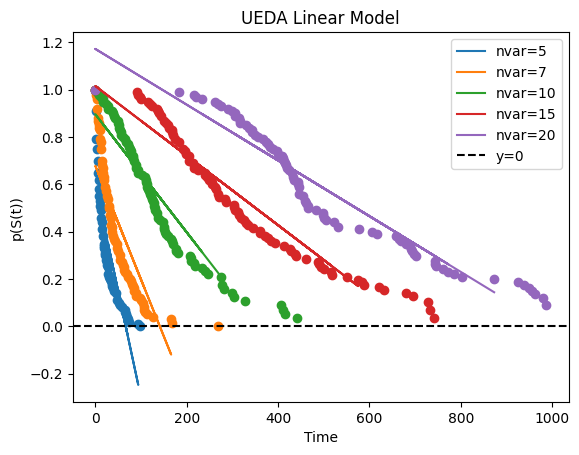

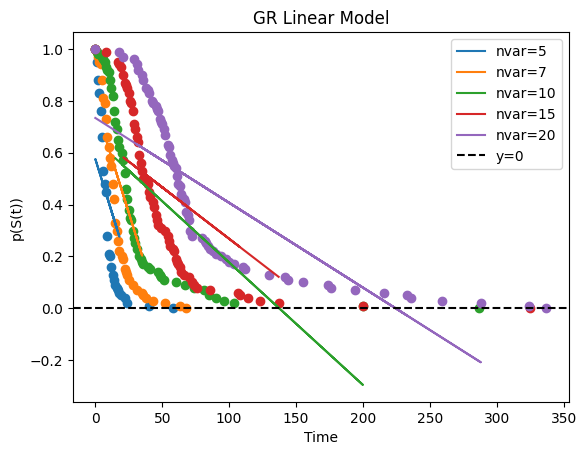

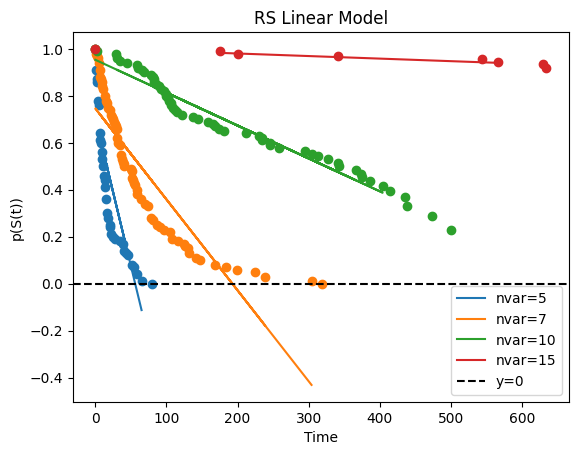

γ =  0.0002 ± 0.0000, 95% CI [ 0.0001 to  0.0002]; se = 0.0000
β = -0.0225 ± 0.0026, 95% CI [-0.0251 to -0.0199]; se = 0.0013
α =  0.7739 ± 0.0451, 95% CI [ 0.7288 to  0.8190]; se = 0.0224
0.6866081766577735
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0112 ± 0.0008, 95% CI [-0.0121 to -0.0104]; se = 0.0004
α =  0.8648 ± 0.0330, 95% CI [ 0.8317 to  0.8978]; se = 0.0165
0.2913556583005959
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0051 ± 0.0002, 95% CI [-0.0052 to -0.0049]; se = 0.0001
α =  1.0656 ± 0.0154, 95% CI [ 1.0502 to  1.0810]; se = 0.0077
0.1471782577577665
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0029 ± 0.0002, 95% CI [-0.0031 to -0.0027]; se = 0.0001
α =  1.2276 ± 0.0305, 95% CI [ 1.1971 to  1.2581]; se = 0.0153
0.49853169271594056
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0019 ± 0.0003, 95% CI [-0.0022 to -0.0016]; se = 0.0002
α =  1.3399 ± 0.0812, 95% CI [ 1.2587 to 

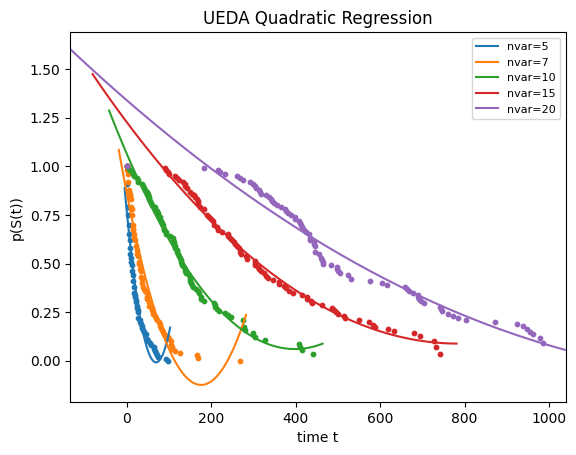

γ =  0.0009 ± 0.0002, 95% CI [ 0.0007 to  0.0011]; se = 0.0001
β = -0.0637 ± 0.0106, 95% CI [-0.0744 to -0.0531]; se = 0.0051
α =  0.9162 ± 0.0994, 95% CI [ 0.8168 to  1.0156]; se = 0.0478
0.31972146731188483
γ =  0.0005 ± 0.0001, 95% CI [ 0.0004 to  0.0006]; se = 0.0000
β = -0.0485 ± 0.0047, 95% CI [-0.0531 to -0.0438]; se = 0.0023
α =  1.0393 ± 0.0563, 95% CI [ 0.9830 to  1.0955]; se = 0.0276
0.22195685325111988
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0001]; se = 0.0000
β = -0.0150 ± 0.0026, 95% CI [-0.0176 to -0.0125]; se = 0.0013
α =  0.8704 ± 0.0840, 95% CI [ 0.7864 to  0.9543]; se = 0.0417
0.5612523370692961
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0138 ± 0.0018, 95% CI [-0.0156 to -0.0119]; se = 0.0009
α =  1.0160 ± 0.0808, 95% CI [ 0.9353 to  1.0968]; se = 0.0402
-0.22368960528220982
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0111 ± 0.0013, 95% CI [-0.0124 to -0.0098]; se = 0.0007
α =  1.1314 ± 0.0749, 95% CI [ 1.0565 

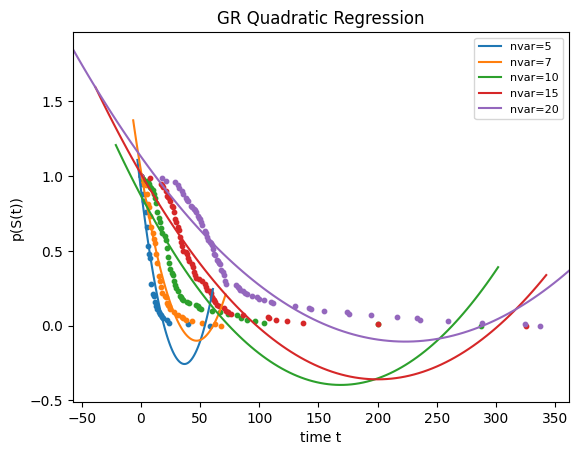

γ =  0.0003 ± 0.0001, 95% CI [ 0.0002 to  0.0003]; se = 0.0000
β = -0.0308 ± 0.0049, 95% CI [-0.0357 to -0.0260]; se = 0.0024
α =  0.8465 ± 0.0620, 95% CI [ 0.7845 to  0.9085]; se = 0.0304
0.32224284543754944
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0086 ± 0.0006, 95% CI [-0.0092 to -0.0080]; se = 0.0003
α =  0.8993 ± 0.0271, 95% CI [ 0.8722 to  0.9264]; se = 0.0136
0.39096678109675853
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0019 ± 0.0003, 95% CI [-0.0022 to -0.0016]; se = 0.0001
α =  0.9939 ± 0.0248, 95% CI [ 0.9691 to  1.0187]; se = 0.0124
0.936410274861413
γ = -0.0000 ± 0.0000, 95% CI [-0.0000 to  0.0000]; se = 0.0000
β = -0.0000 ± 0.0001, 95% CI [-0.0002 to  0.0001]; se = 0.0001
α =  0.9980 ± 0.0198, 95% CI [ 0.9781 to  1.0178]; se = 0.0077
0.9423196877938298


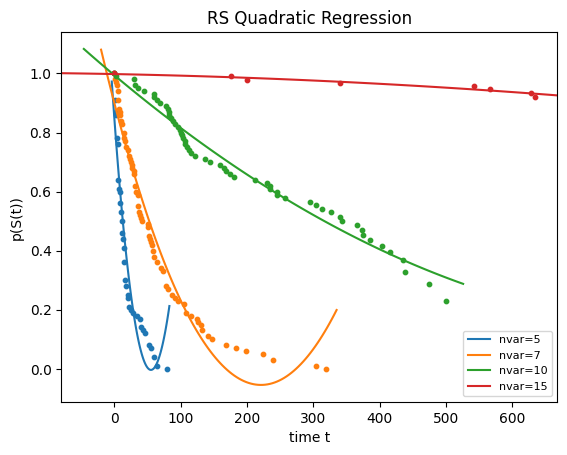

In [15]:
nvars = [5, 7, 10, 15, 20]

dataDictArrayoUEDA = [makeMNQDf(nvar, "UEDA", True) for nvar in nvars]
dataDictArrayoRS = [makeMNQDf(nvar, "RS", True) for nvar in nvars]
dataDictArrayoGR = [makeMNQDf(nvar, "GR", True) for nvar in nvars]


errorsLinearUEDA = doSimpleLinearRegression(dataDictArrayoUEDA, "UEDA", True)
errorsLinearGR = doSimpleLinearRegression(dataDictArrayoGR, "GR", True)
errorsLinearRS = doSimpleLinearRegression(dataDictArrayoRS, "RS", True)

errorsQuadraticUEDA = doQuadraticRegression(dataDictArrayoUEDA, "UEDA", True)
errorsQuardraticGR = doQuadraticRegression(dataDictArrayoGR, "GR", True)
errorsQuadraticRS = doQuadraticRegression(dataDictArrayoRS, "RS", True)

In [16]:
nvars = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

dataDictArrayoUEDA = [makeMNQDf(nvar, "UEDA", True) for nvar in nvars]
dataDictArrayoRS = [makeMNQDf(nvar, "RS", True) for nvar in nvars]
dataDictArrayoGR = [makeMNQDf(nvar, "GR", True) for nvar in nvars]

errorsLinearUEDA = doSimpleLinearRegression(dataDictArrayoUEDA, "UEDA", False)
errorsLinearGR = doSimpleLinearRegression(dataDictArrayoGR, "GR", False)
errorsLinearRS = doSimpleLinearRegression(dataDictArrayoRS, "RS", False)

errorsQuadraticUEDA = doQuadraticRegression(dataDictArrayoUEDA, "UEDA", False)
errorsQuardraticGR = doQuadraticRegression(dataDictArrayoGR, "GR", False)
errorsQuadraticRS = doQuadraticRegression(dataDictArrayoRS, "RS", False)

γ =  0.0002 ± 0.0000, 95% CI [ 0.0001 to  0.0002]; se = 0.0000
β = -0.0225 ± 0.0026, 95% CI [-0.0251 to -0.0199]; se = 0.0013
α =  0.7739 ± 0.0451, 95% CI [ 0.7288 to  0.8190]; se = 0.0224
0.6866081766577735
γ =  0.0001 ± 0.0000, 95% CI [ 0.0000 to  0.0001]; se = 0.0000
β = -0.0142 ± 0.0017, 95% CI [-0.0159 to -0.0125]; se = 0.0008
α =  0.7849 ± 0.0476, 95% CI [ 0.7374 to  0.8325]; se = 0.0236
0.40885969309746684
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0112 ± 0.0008, 95% CI [-0.0121 to -0.0104]; se = 0.0004
α =  0.8648 ± 0.0330, 95% CI [ 0.8317 to  0.8978]; se = 0.0165
0.2913556583005959
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0089 ± 0.0004, 95% CI [-0.0093 to -0.0085]; se = 0.0002
α =  0.9912 ± 0.0211, 95% CI [ 0.9701 to  1.0124]; se = 0.0106
0.5612762797036512
γ =  0.0000 ± 0.0000, 95% CI [ 0.0000 to  0.0000]; se = 0.0000
β = -0.0070 ± 0.0003, 95% CI [-0.0072 to -0.0067]; se = 0.0001
α =  0.9856 ± 0.0170, 95% CI [ 0.9686 to 

In [17]:
print(errorsQuadraticRS)

[{'mae5': 0.0609197813935487, 'mse5': 0.004966784540207409}, {'mae6': 0.06152499238210202, 'mse6': 0.004561636767017006}, {'mae7': 0.052701721468330694, 'mse7': 0.00366439646098139}, {'mae8': 0.02566947206893372, 'mse8': 0.000998800922503818}, {'mae9': 0.024833824221543496, 'mse9': 0.0007356487995755984}, {'mae10': 0.028621294465508304, 'mse10': 0.0010292311677126116}, {'mae11': 0.012233411643910865, 'mse11': 0.00018922414214362965}, {'mae12': 0.013992507449463721, 'mse12': 0.00022409094042802547}, {'mae13': 0.0014545409574350243, 'mse13': 2.216105137020024e-06}, {'mae14': 0.003982319636843701, 'mse14': 1.989166278140228e-05}, {'mae15': 0.0032270799301529762, 'mse15': 1.061946437161985e-05}, {'mae16': 0.007577167453058864, 'mse16': 5.943148439678547e-05}, {'mae17': 295392.01, 'mse17': 87256439571.8401}, {'mae23': 32942.01, 'mse23': 1085176022.8401}]


##### Evaluation of Simple Models


In [18]:
tmpDf1 = tmpDf2 = tmpDf3 = tmpDf4 = tmpDf5 = tmpDf6 = pd.DataFrame()

for dict in errorsLinearUEDA:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Linear UEDA'})
    tmpDf1 = pd.concat([tmpDf1, df1], ignore_index=False)
for dict in errorsLinearRS:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Linear RS'})
    tmpDf2 = pd.concat([tmpDf2, df1], ignore_index=False)
for dict in errorsLinearGR:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Linear GR'})
    tmpDf3 = pd.concat([tmpDf3, df1], ignore_index=False)


for dict in errorsQuadraticUEDA:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Quadratic UEDA'})
    tmpDf4 = pd.concat([tmpDf4, df1], ignore_index=False)
for dict in errorsQuadraticRS:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Quadratic RS'})
    tmpDf5 = pd.concat([tmpDf5, df1], ignore_index=False)
for dict in errorsQuardraticGR:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Quadratic GR'})
    tmpDf6 = pd.concat([tmpDf6, df1], ignore_index=False)

errorsOverallDf = pd.concat([tmpDf1, tmpDf2, tmpDf3, tmpDf4, tmpDf5, tmpDf6], axis=1)

pd.set_option('display.max_rows', None)
errorsOverallDf.head()

,Linear UEDA,Linear RS,Linear GR,Quadratic UEDA,Quadratic RS,Quadratic GR
mae5,0.103844,0.106039,0.213947,0.049835,0.060920,0.052754
mse5,0.016093,0.017160,0.063289,0.002724,0.004967,0.004608
mae6,0.143025,0.131448,0.190072,0.086946,0.061525,0.072995
mse6,0.023644,0.020663,0.037802,0.008310,0.004562,0.007319
mae7,0.139490,0.147373,0.200599,0.059397,0.052702,0.065086


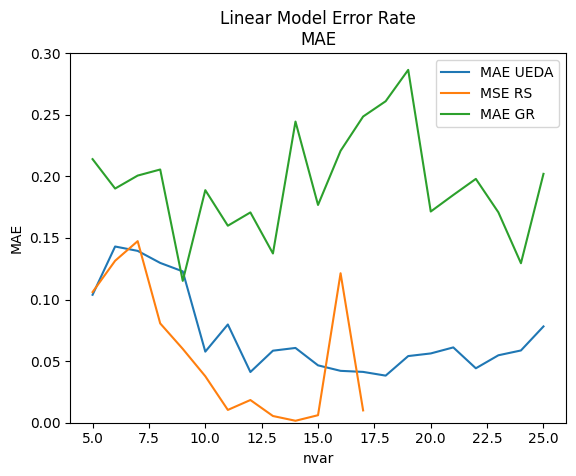

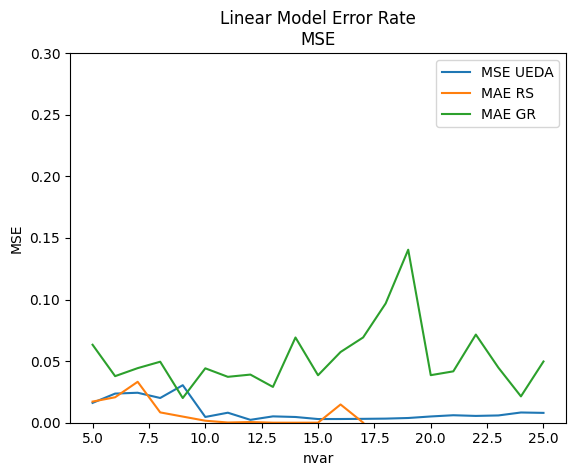

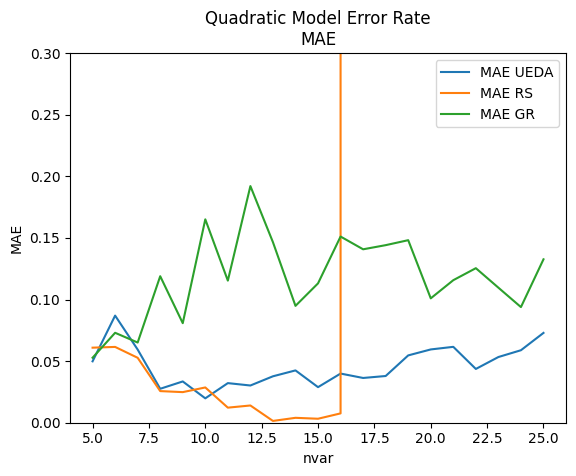

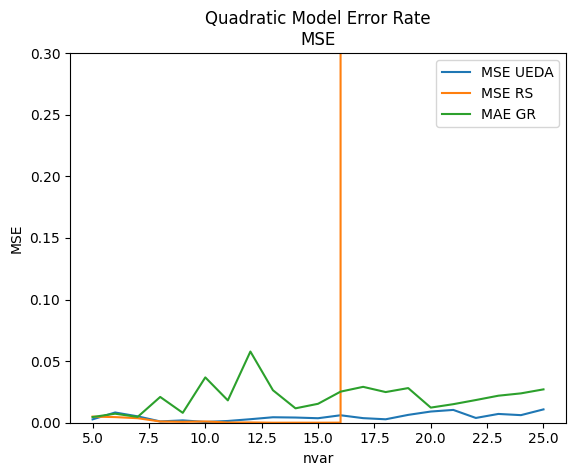

In [19]:
# Plotting
mseDf = errorsOverallDf[errorsOverallDf.index.str.contains('mse')]
maeDf = errorsOverallDf[errorsOverallDf.index.str.contains('mae')]

pYs = mseDf.index
index = [int(re.search(r'\d+', pY).group()) for pY in pYs]      # [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
plt.plot(index, maeDf["Linear UEDA"], label="MAE UEDA")
plt.plot(index, maeDf["Linear RS"], label="MSE RS")
plt.plot(index, maeDf["Linear GR"], label="MAE GR")
plt.ylabel("MAE")
plt.xlabel("nvar")
plt.title("Linear Model Error Rate\nMAE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()



plt.plot(index, mseDf["Linear UEDA"], label="MSE UEDA")
plt.plot(index, mseDf["Linear RS"], label="MAE RS")
plt.plot(index, mseDf["Linear GR"], label="MAE GR")
plt.ylabel("MSE")
plt.xlabel("nvar")
plt.title("Linear Model Error Rate\nMSE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()


plt.plot(index, maeDf["Quadratic UEDA"], label="MAE UEDA")
plt.plot(index, maeDf["Quadratic RS"], label="MAE RS")
plt.plot(index, maeDf["Quadratic GR"], label="MAE GR")
plt.ylabel("MAE")
plt.xlabel("nvar")
plt.title("Quadratic Model Error Rate\nMAE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()


plt.plot(index, mseDf["Quadratic UEDA"], label="MSE UEDA")
plt.plot(index, mseDf["Quadratic RS"], label="MSE RS")
plt.plot(index, mseDf["Quadratic GR"], label="MAE GR")
plt.ylabel("MSE")
plt.xlabel("nvar")
plt.title("Quadratic Model Error Rate\nMSE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()



Regarding those very simple models for UEDA, RS and GR, it becomes clear, that Survival Analysis Models are suited for the algorithms UEDA and GR.
While as, RS brings only miserable error rates. Satisfying was especially the quadratic fitting. <br> <br>
Furthermore, It becomes obvious that the error rate is not co-dependant with the number of variables optimized by each algorithm for UEDA and GR. A tendency of greater error can be assumed. However, especially with regards to the middle range [10; 14] most falsified predictions occured.The RS model is useful for small numbers of nvars, but cannot be guaranteed to lead to suitable outcomes for nvar > 15 due to lacking data. <br>
The scruntiny is falsified by stopped optimization in regards to high nvars. However, the Survival Analysis Curves are still recommended compared to making a guess only.
<br>
Therefore, two more complex models are implemented further to test, whether they could bring an advantage or if Survival Analysis might be suitable with more complex models for RS even.

### Topic 3: Exponential and SVR Modeling

In [20]:
# Re-Use
#dataDictArrayoUEDA
#dataDictArrayoRS
#dataDictArrayoGR

# Exponential Modeling
# Source for Code: https://stackoverflow.com/questions/3938042/fitting-exponential-decay-with-no-initial-guessing
# Careful! Fitting fails due to incompatible dataset in tain_test_split for GR
def makeExpModel(arrayo, alg, nvars):
    all_errors = []
    pylab.clf()
    for dataDict in arrayo:
        nvar = dataDict["nvar"].iloc[0] 
        if nvar in nvars:
            x = np.array(dataDict.index)
            y = np.array(dataDict["p(S(t))"])
            try:
                xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=4)
            
                

                smoothx = np.linspace(x[0], x[-1], len(xTrain))
                guess_a, guess_b, guess_c = 200, -0.01, 300
                guess = [guess_a, guess_b, guess_c]

                exp_decay = lambda x, A, t, y0: A * np.exp(x * t) + y0

                params, cov = curve_fit(exp_decay, x, y, p0=guess, maxfev=4000)
                A, t, y0 = params

                # print "A = %s\nt = %s\ny0 = %s\n" % (A, t, y0)
                best_fit = lambda x: A * np.exp(t * x) + y0

                # Calculate MAE and MSE ------------------------------------
                mae = 0
                mse = 0
                a = 0
                yPred = []

                for i, y_actual in enumerate(yTest):
                        y_pred = best_fit(xTest[i])  # Use the lambda function for prediction
                        yPred.append(y_pred)

                        mae += abs(y_actual - y_pred)
                        mse += (y_actual - y_pred)**2

                try:
                        mae /= len(yTest)
                        mse /= len(yTest)
                except ZeroDivisionError:
                        print("No zero division")
                        return np.nan

                name1 = f"mae{nvar}"
                name2 = f"mse{nvar}"

                errorArr = {name1: mae, name2: mse}
                all_errors.append(errorArr)
        

                # ----------------------------------------------------------
                pylab.title(f"Exponential Model for {alg}")
                pylab.scatter(x, y)
                pylab.plot(smoothx, best_fit(smoothx), label=f"nvar={nvar}")
            except ValueError:
                  print("valError")
    plt.axhline(y=0, color='black', linestyle='--')
    pylab.legend()
    pylab.show()
        
    return all_errors

# source: https://thinkingneuron.com/how-to-create-an-svm-model-for-regression-in-python/ and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
# kernel: linear, poly, rbf, sigmoid, precomputed
def makeSVRModel(arrayo, alg, nvars, kernel):
    all_errors = []
    pylab.clf()
    for dataDict in arrayo:
        nvar = dataDict["nvar"].iloc[0] 
        if nvar in nvars:
                x = np.array(dataDict.index).reshape(-1, 1)
                y = np.array(dataDict["p(S(t))"]).reshape(-1, 1)
        
                xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=4)
                RegModel = svm.SVR(C=2, kernel=kernel)

                SVM = RegModel.fit(xTrain, yTrain)
                yPred = SVM.predict(xTest)

                
                # Calculate MAE and MSE ------------------------------------
                mae = 0
                mse = 0
                a = 0

                for i in range(len(yTest)-1):
                        mae += abs(yTest[i] - yPred[i])
                        mse += (yTest[i] - yPred[i])**2
                
                try: 
                        mae /= len(yTest)
                        mse /= len(yTest)

                except ZeroDivisionError:
                        print("no zero division")
                        return np.nan
                
                name1 = f"mae{nvar}"
                name2 = f"mse{nvar}"

                errorArr = {name1: mae, name2: mse}
                all_errors.append(errorArr)
                
                # ----------------------------------------------------------
                plt.scatter(x, y, label=f"nvar={nvar}")
                xPlotter = np.linspace(min(x), max(x), 100).reshape(-1, 1)
                yPlotter = SVM.predict(xPlotter)
                plt.plot(xPlotter, yPlotter, label=f"nvar={nvar}")
    plt.title(f"SVM Model for {alg}\nkernel={kernel}")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.show()
        
    return all_errors


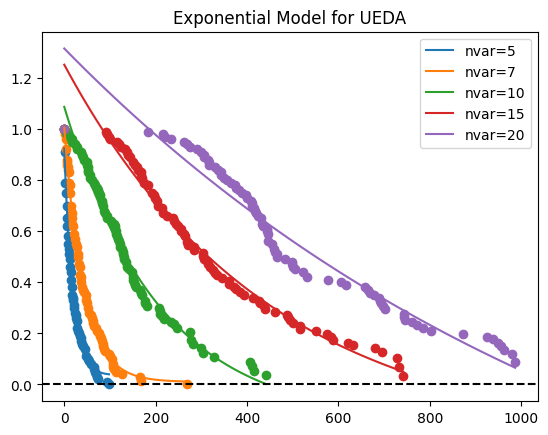

valError


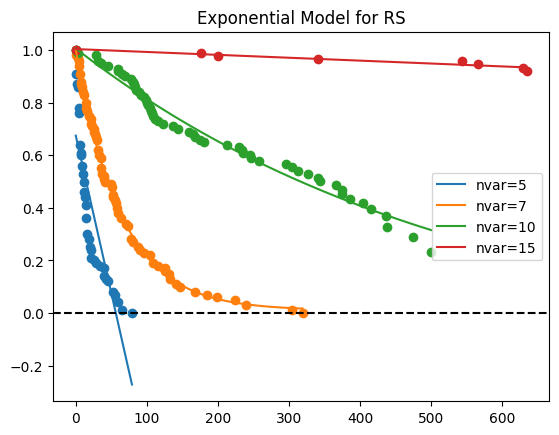

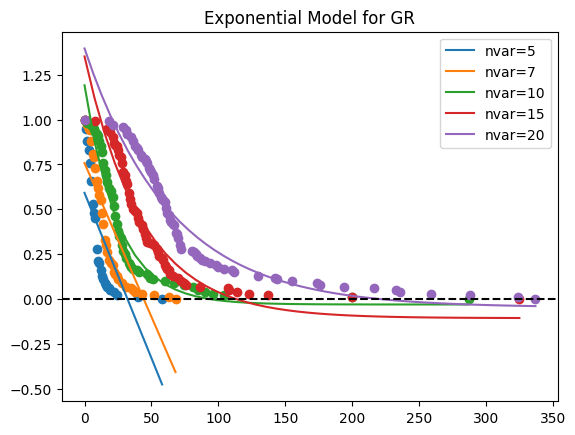

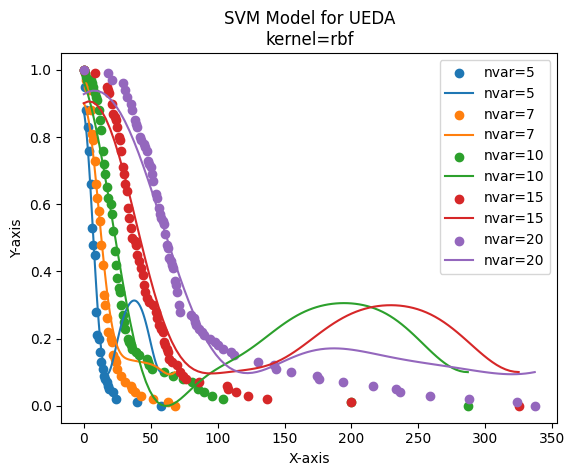

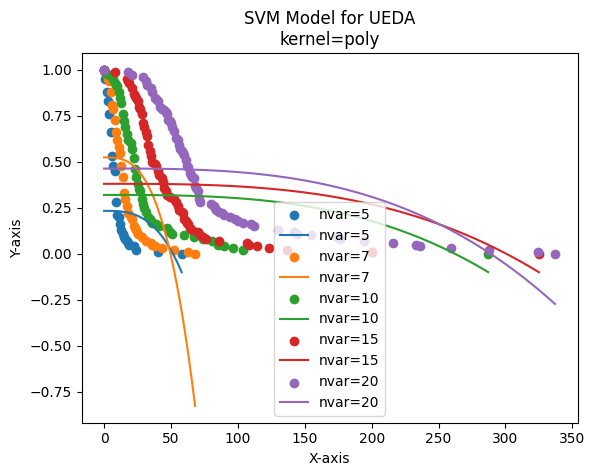

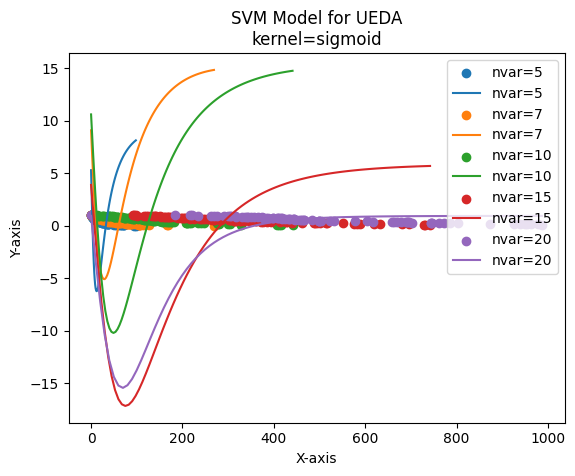

In [21]:
nvars = [5, 7, 10, 15, 20]


errorsExpUEDA = makeExpModel(dataDictArrayoUEDA, "UEDA", nvars)
errorsExpRS = makeExpModel(dataDictArrayoRS, "RS", nvars)
errorsExpGR = makeExpModel(dataDictArrayoGR, "GR", nvars)

# rbf, sigmoid and poly Kernel appears to be noted suited at all due to the shape of original data:
errorsSVRrbfUEDA = makeSVRModel(dataDictArrayoGR, "UEDA", nvars, "rbf")
errorsSVRPolyUEDA = makeSVRModel(dataDictArrayoGR, "UEDA", nvars, "poly")
errorsSVRSigmoidUEDA = makeSVRModel(dataDictArrayoUEDA, "UEDA", nvars, "sigmoid")


Well, it is shown that the fitting of model is crucial and indeed; Sigmoid, rbf and poly perform horribly. However, the exponential model is in the followin plotted as well and performs faily well in order to smooth the data.

In [22]:
del tmpDf1, tmpDf2, tmpDf3, tmpDf4, tmpDf5, tmpDf6
tmpDf1 = tmpDf2 = tmpDf3 = tmpDf4 = tmpDf5 = tmpDf6 = pd.DataFrame()

for dict in errorsExpUEDA:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Exp UEDA'})
    tmpDf1 = pd.concat([tmpDf1, df1], ignore_index=False)
for dict in errorsExpRS:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Exp RS'})
    tmpDf2 = pd.concat([tmpDf2, df1], ignore_index=False)
for dict in errorsQuardraticGR:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Exp GR'})
    tmpDf3 = pd.concat([tmpDf3, df1], ignore_index=False)

# For the sake of completeness, some horrible models: Enjoy :)
for dict in errorsSVRrbfUEDA:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'RBF UEDA'})
    tmpDf4 = pd.concat([tmpDf4, df1], ignore_index=False)
for dict in errorsSVRPolyUEDA:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Poly UEDA'})
    tmpDf5 = pd.concat([tmpDf5, df1], ignore_index=False)
for dict in errorsSVRSigmoidUEDA:
    df1 = pd.DataFrame.from_dict(dict, orient='index', columns=["value"])
    df1 = df1.rename(columns={'value':'Sigmoid UEDA'})
    tmpDf6 = pd.concat([tmpDf6, df1], ignore_index=False)

errorsOverallDf2 = pd.concat([tmpDf1, tmpDf2, tmpDf3, tmpDf4, tmpDf5, tmpDf6], axis=1)
errorsOverallDf = pd.concat([errorsOverallDf, errorsOverallDf2], axis=1)

In [23]:
errorsOverallDf.head()
# It becomes claer, that in the exponential function not always values are in for each nvar

,Linear UEDA,Linear RS,Linear GR,Quadratic UEDA,Quadratic RS,Quadratic GR,Exp UEDA,Exp RS,Exp GR,RBF UEDA,Poly UEDA,Sigmoid UEDA
mae5,0.103844,0.106039,0.213947,0.049835,0.060920,0.052754,0.012204,0.133047,0.052754,0.128506,0.333378,4.507145
mse5,0.016093,0.017160,0.063289,0.002724,0.004967,0.004608,0.000293,0.020067,0.004608,0.026540,0.198376,25.099135
mae6,0.143025,0.131448,0.190072,0.086946,0.061525,0.072995,NaN,NaN,0.072995,NaN,NaN,NaN
mse6,0.023644,0.020663,0.037802,0.008310,0.004562,0.007319,NaN,NaN,0.007319,NaN,NaN,NaN
mae7,0.139490,0.147373,0.200599,0.059397,0.052702,0.065086,0.012026,0.018093,0.065086,0.063304,0.236805,4.364979


In [24]:
mseDf = errorsOverallDf[errorsOverallDf.index.str.contains('mse')]
maeDf = errorsOverallDf[errorsOverallDf.index.str.contains('mae')]

mseDf

,Linear UEDA,Linear RS,Linear GR,Quadratic UEDA,Quadratic RS,Quadratic GR,Exp UEDA,Exp RS,Exp GR,RBF UEDA,Poly UEDA,Sigmoid UEDA
mse5,0.016093,0.017160,0.063289,0.002724,4.966785e-03,0.004608,0.000293,0.020067,0.004608,0.026540,0.198376,25.099135
mse6,0.023644,0.020663,0.037802,0.008310,4.561637e-03,0.007319,NaN,NaN,0.007319,NaN,NaN,NaN
mse7,0.024328,0.033216,0.044299,0.005179,3.664396e-03,0.004729,0.000200,0.000414,0.004729,0.004920,0.084200,26.160522
mse8,0.020080,0.008377,0.049518,0.001054,9.988009e-04,0.020926,NaN,NaN,0.020926,NaN,NaN,NaN
mse9,0.030455,0.004994,0.020049,0.001912,7.356488e-04,0.008032,NaN,NaN,0.008032,NaN,NaN,NaN
mse10,0.004669,0.001622,0.044155,0.000620,1.029231e-03,0.036794,0.001244,0.001323,0.036794,0.013227,0.170760,64.484116
mse11,0.008127,0.000178,0.037254,0.001419,1.892241e-04,0.018138,NaN,NaN,0.018138,NaN,NaN,NaN
mse12,0.002346,0.000552,0.039069,0.002857,2.240909e-04,0.057777,NaN,NaN,0.057777,NaN,NaN,NaN
mse13,0.005155,0.000030,0.029069,0.004440,2.216105e-06,0.026380,NaN,NaN,0.026380,NaN,NaN,NaN
mse14,0.004652,0.000003,0.069184,0.004209,1.989166e-05,0.011689,NaN,NaN,0.011689,NaN,NaN,NaN


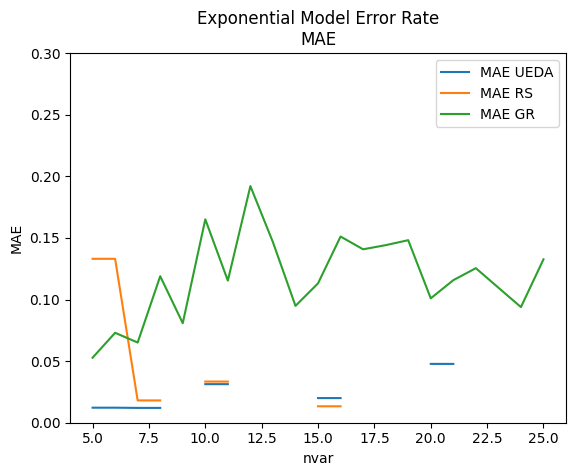

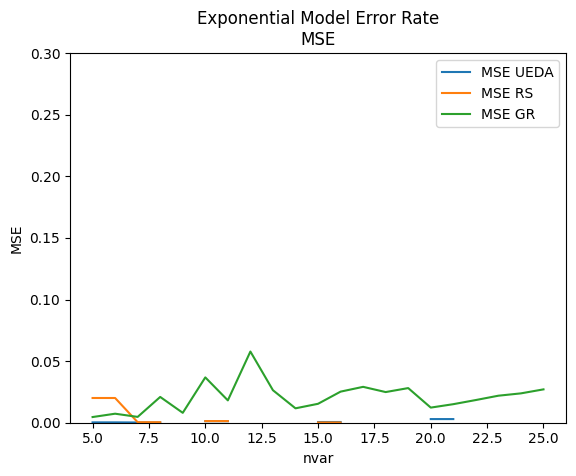

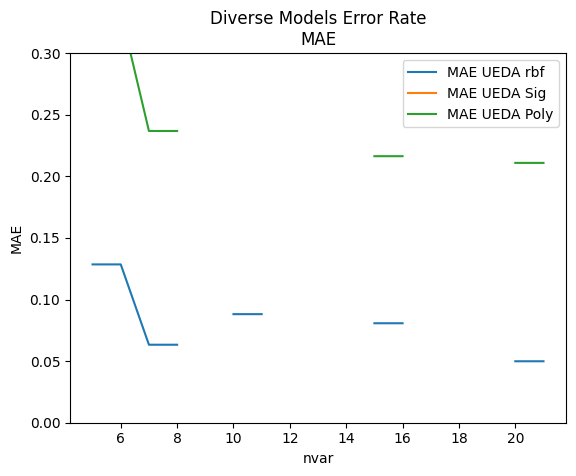

In [25]:
mseDf = errorsOverallDf[errorsOverallDf.index.str.contains('mse')]
maeDf = errorsOverallDf[errorsOverallDf.index.str.contains('mae')]

pYs = mseDf.index
index = [int(re.search(r'\d+', pY).group()) for pY in pYs]      # [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
plt.plot(index, maeDf["Exp UEDA"].fillna(method='ffill', limit=1), label="MAE UEDA")
plt.plot(index, maeDf["Exp RS"].fillna(method='ffill', limit=1), label="MAE RS")
plt.plot(index, maeDf["Exp GR"].fillna(method='ffill', limit=1), label="MAE GR")
plt.ylabel("MAE")
plt.xlabel("nvar")
plt.title("Exponential Model Error Rate\nMAE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()

plt.plot(index, mseDf["Exp UEDA"].fillna(method='ffill', limit=1), label="MSE UEDA")
plt.plot(index, mseDf["Exp RS"].fillna(method='ffill', limit=1), label="MSE RS")
plt.plot(index, mseDf["Exp GR"].fillna(method='ffill', limit=1), label="MSE GR")
plt.ylabel("MSE")
plt.xlabel("nvar")
plt.title("Exponential Model Error Rate\nMSE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()



# Maybe (?) useful rubbish
plt.plot(index, maeDf["RBF UEDA"].fillna(method='ffill', limit=1), label="MAE UEDA rbf")
plt.plot(index, maeDf["Sigmoid UEDA"].fillna(method='ffill', limit=1), label="MAE UEDA Sig")
plt.plot(index, maeDf["Poly UEDA"].fillna(method='ffill', limit=1), label="MAE UEDA Poly")
plt.ylabel("MAE")
plt.xlabel("nvar")
plt.title("Diverse Models Error Rate\nMAE")
plt.ylim(0, 0.3)
plt.legend()
plt.show()

### Topic 4: Log-Rank-Test
The Log Rank Test is a statistical test that compares the survival times of two or more groups. It is based on the null hypothesis that there is no difference between the groups in terms of survival. The test statistic is calculated by comparing the observed number of events (deaths or failures) in each group with the expected number under the null hypothesis. The p-value is then obtained from the chi-square distribution with degrees of freedom equal to the number of groups minus one.

We will use the `lifelines` library in Python to perform the Log Rank Test. We will compare the following groups:

- UEDA vs GR vs RS for nvars = 10
- UEDA vs GR vs RS for nvars = 20
- UEDA vs GR vs RS for nvars = 30
- UEDA for nvars = 10 vs UEDA for nvars = 20 vs UEDA for nvars = 30
- GR for nvars = 10 vs GR for nvars = 20 vs GR for nvars = 30
- RS for nvars = 10 vs RS for nvars = 20 vs RS for nvars = 30

In [5]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Read the CSV file
csv_file = 'QUBOClusteringData.csv'
df = pd.read_csv(csv_file)

def compare_groups(groups, labels, title):
  # Initialize the Kaplan-Meier fitter
  kmf = KaplanMeierFitter()
  # Initialize an empty list to store the survival curves
  curves = []
  # Loop through the groups
  for group in groups:
    # Drop the rows where 'tsolve' is NaN
    group = group.dropna(subset=['tsolve'])
    # Extract the survival time and event indicator
    T = group['tsolve']
    E = ~pd.isna(T)
    # Fit the Kaplan-Meier model
    label = labels.pop(0)
    kmf.fit(T, E, label=label)
    # Append the survival probabilities to the list
    curves.append(kmf.survival_function_[label].values)
  # Ensure the survival probabilities have the same length
  max_length = max(len(curve) for curve in curves)
  curves = [np.pad(curve, (0, max_length - len(curve)), 'edge') for curve in curves]
  # # Plot the survival curves
  # for curve, label in zip(curves, labels):
  #   plt.plot(curve, label=label)
  # # Set the title, xlabel and ylabel
  # plt.title(title)
  # plt.xlabel('Time')
  # plt.ylabel('Survival probability')
  # plt.legend()
  # Perform the Log Rank Test
  results = logrank_test(*curves)
  # Print the test summary
  print(results.summary)
  # Return the results
  return results



In [6]:
# Compare UEDA vs GR vs RS for nvars = 10
groups = [df[(df['alg'] == 'UEDA') & (df['nvars'] == 10)],
          df[(df['alg'] == 'GR') & (df['nvars'] == 10)],
          df[(df['alg'] == 'RS') & (df['nvars'] == 10)]]
labels = ['UEDA', 'GR', 'RS']
title = 'UEDA vs GR vs RS for nvars = 10'
results_1 = compare_groups(groups, labels, title)

   test_statistic         p   -log2(p)
0       22.117484  0.000003  18.572817


The results of the first Log Rank Test are shown above. The p-values indicate the probability of observing the data under the null hypothesis of no difference between the groups. A small p-value (less than 0.05) suggests that we can reject the null hypothesis and conclude that there is a significant difference between the groups.

- UEDA vs GR vs RS for nvars = 10: The p-value is 0.000003, which means that there is a significant difference between the survival curves of UEDA, GR and RS for nvars = 10.

In [8]:
# Compare UEDA vs GR vs RS for nvars = 20
groups = [df[(df['alg'] == 'UEDA') & (df['nvars'] == 20)],
          df[(df['alg'] == 'GR') & (df['nvars'] == 20)],
          df[(df['alg'] == 'RS') & (df['nvars'] == 20)]]
labels = ['UEDA', 'GR', 'RS']
title = 'UEDA vs GR vs RS for nvars = 20'
results_2 = compare_groups(groups, labels, title)



ValueError: Values must be numeric: no strings, datetimes, objects, etc.

In [9]:
# Compare UEDA vs GR vs RS for nvars = 30
groups = [df[(df['alg'] == 'UEDA') & (df['nvars'] == 30)],
          df[(df['alg'] == 'GR') & (df['nvars'] == 30)],
          df[(df['alg'] == 'RS') & (df['nvars'] == 30)]]
labels = ['UEDA', 'GR', 'RS']
title = 'UEDA vs GR vs RS for nvars = 30'
results_3 = compare_groups(groups, labels, title)


ValueError: Values must be numeric: no strings, datetimes, objects, etc.

In [10]:

# Compare UEDA for nvars = 10 vs UEDA for nvars = 20 vs UEDA for nvars = 30
groups = [df[(df['alg'] == 'UEDA') & (df['nvars'] == 10)],
          df[(df['alg'] == 'UEDA') & (df['nvars'] == 20)],
          df[(df['alg'] == 'UEDA') & (df['nvars'] == 30)]]
labels = ['UEDA for nvars = 10', 'UEDA for nvars = 20', 'UEDA for nvars = 30']
title = 'UEDA for nvars = 10 vs UEDA for nvars = 20 vs UEDA for nvars = 30'
results_4 = compare_groups(groups, labels, title)


   test_statistic         p  -log2(p)
0        2.610463  0.106161  3.235677


In [11]:

# Compare GR for nvars = 10 vs GR for nvars = 20 vs GR for nvars = 30
groups = [df[(df['alg'] == 'GR') & (df['nvars'] == 10)],
          df[(df['alg'] == 'GR') & (df['nvars'] == 20)],
          df[(df['alg'] == 'GR') & (df['nvars'] == 30)]]
labels = ['GR for nvars = 10', 'GR for nvars = 20', 'GR for nvars = 30']
title = 'GR for nvars = 10 vs GR for nvars = 20 vs GR for nvars = 30'
results_5 = compare_groups(groups, labels, title)


   test_statistic         p  -log2(p)
0        1.339355  0.247148  2.016554


In [12]:

# Compare RS for nvars = 10 vs RS for nvars = 20 vs RS for nvars = 30
groups = [df[(df['alg'] == 'RS') & (df['nvars'] == 10)],
          df[(df['alg'] == 'RS') & (df['nvars'] == 20)],
          df[(df['alg'] == 'RS') & (df['nvars'] == 30)]]
labels = ['RS for nvars = 10', 'RS for nvars = 20', 'RS for nvars = 30']
title = 'RS for nvars = 10 vs RS for nvars = 20 vs RS for nvars = 30'
results_6 = compare_groups(groups, labels, title)

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

Particularly when RS with `nvars` more than 20 is included in the groups that are being plotted, the output of the function includes a `ValueError`. This is due to the fact that a big potion if these values end up being `NaN`. Therefore a method to handle these `NaN`-values needs to be established to be certain of any outputs or conclusions made, inlcuding the previous Kaplan-Meier curves.

### Topic 5: Dealing with very few successful runs

### Modeling Conclusions:
The smoothing of the Survival curve is crucial in order to estimate new data. Some models work better than others do.<br>
Furthermore, the choice of Algorithm determines, which smoothing model should be used. Some optimzer seem to not suit the problem at all, such as GR for many Variables to be optimized.<br>
Modeling so far has suggested, that runtimes can be estimated by Survival Analysis. 